In [1]:
import re
import ast
import json
from glob import glob
from collections import Counter
from scipy.stats import pearsonr,spearmanr
from numpy import mean, median

In [2]:
eval_data = [json.loads(l)
                     for l in open("../data/open-eval.jsonl").read().splitlines()]
with open("lib2domain.json") as f:
    lib2domain = json.load(f)

In [3]:
def libs2domains(libs):
    domains = [lib2domain[lib] if lib in lib2domain else "Generic"
            for lib in libs]
    return list(set(domains))
total_domains = Counter([domain for sample in eval_data for domain in libs2domains(sample["libs"])])

task2domains = {sample["task_id"]: libs2domains(sample["libs"]) for sample in eval_data}

In [7]:
model_results = dict()
for model in ["gpt-4-turbo-2024-04-09", "gpt-3.5-turbo-0125", "CodeQwen1.5-7B-Chat", "OpenCodeInterpreter-DS-6.7B", 
              "deepseek-coder-6.7b-instruct", "CodeLlama-7b-hf", "starcoder2-7b", "starcoder2-3b"]:
    model_results[model] = json.load(open(f"../results/record_{model}_completions_open-eval.jsonl"))

In [8]:
model_perf = dict()
for model in model_results.keys():
    model_success_domains = Counter([domain for task, result in model_results[model].items() if result for domain in task2domains[task]])
    model_perf[model] = {domain: round(count/total_domains[domain]*100,2) for domain, count in model_success_domains.items()}

print("Pass@1 (n=1, temp=0) on 532 tasks\n")
for model in model_results.keys(): 
    print(model+":", round(len([result for task, result in model_results[model].items() if result])/len(model_results[model])*100,2))

Pass@1 (n=1, temp=0) on 532 tasks

gpt-4-turbo-2024-04-09: 65.6
gpt-3.5-turbo-0125: 52.26
CodeQwen1.5-7B-Chat: 43.05
OpenCodeInterpreter-DS-6.7B: 40.79
deepseek-coder-6.7b-instruct: 41.54
CodeLlama-7b-hf: 31.58
starcoder2-7b: 42.48
starcoder2-3b: 43.42


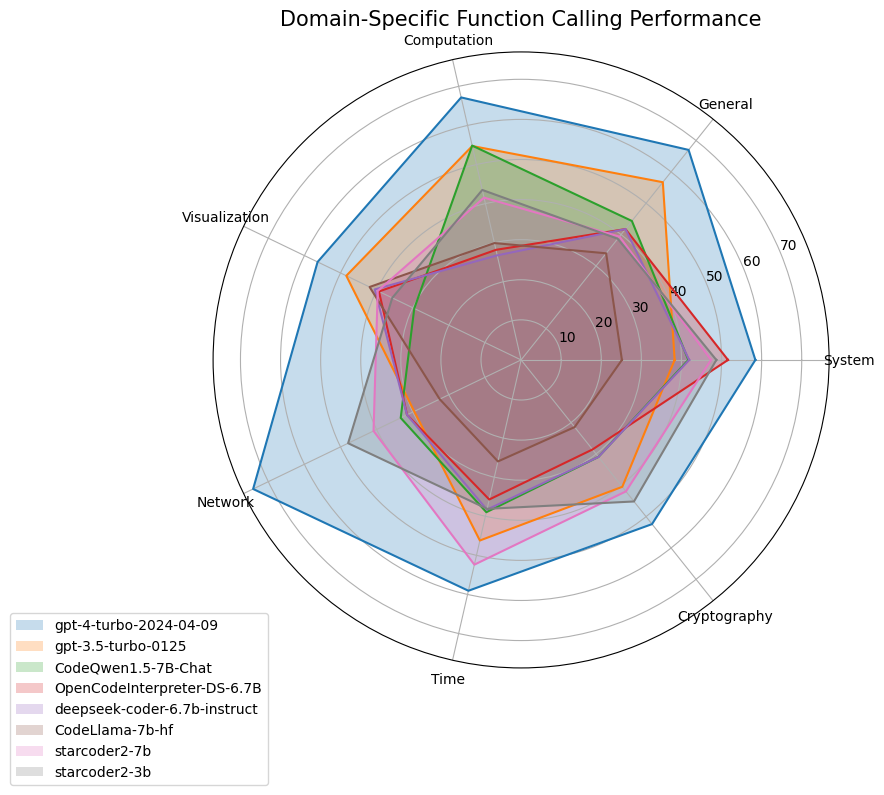

In [9]:
# Radar chart for domains performance using model_perf
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for model in model_results.keys():
    labels=np.array(list(model_perf[model].keys()))
    model_stats=np.array(list(model_perf[model].values()))

    # Number of variables
    num_vars = len(labels)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart is a circle, so it needs to be closed by appending the first value again.
    model_stats = np.concatenate((model_stats,[model_stats[0]]))
    angles += angles[:1]

    
    ax.fill(angles, model_stats, alpha=0.25, label=model)
    ax.plot(angles, model_stats)

    # Labels for each point
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

# Title
plt.title('Domain-Specific Function Calling Performance', size=15)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()